# Try evaluation

In [1]:
import json
import os

import argparse
import torch
import yaml
from tqdm import tqdm
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
from torchvision.ops import nms
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
import numpy as np

import cv2

In [2]:
compound_coef = 0
nms_threshold = 0.5
use_cuda = True
gpu = 0
use_float16 = False
project_name = 'dl2020'
weights_path = '/Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_0428-124856_coef0/model/efficientdet-d0_7900.pth'

In [3]:
print(f'running coco-style evaluation on project {project_name}, weights {weights_path}...')

params = yaml.safe_load(open(f'projects/{project_name}.yml'))
obj_list = params['obj_list']

input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]

running coco-style evaluation on project dl2020, weights /Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_0428-124856_coef0/model/efficientdet-d0_7900.pth...


In [4]:
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]
NUM_SAMPLE_PER_SCENE = 126

In [5]:
val_index = range(int(params['val_set'].split(',')[0]), 130)# int(params['val_set'].split(',')[1]) + 1)
# image_folder = os.path.join(opt.data_path, params.project_name)
folder_path = os.path.join('datasets/', params['project_name'])
# annotation_file = os.path.join(opt.data_path, params.project_name, opt.annotation)
annotation_file = os.path.join('datasets/', params['project_name'], 'annotation_newfeat_2.csv')  

In [6]:
val_index

range(128, 130)

In [7]:
def aspectaware_resize_padding(image, width, height, interpolation=None, means=None):
    old_h, old_w, c = image.shape

    # Get new wh to higher 512, lower scaled accordingly
    if old_w > old_h:
        new_w = width
        new_h = int(width / old_w * old_h)
    else:
        new_w = int(height / old_h * old_w)
        new_h = height

    # Initialize a square 512*512
    canvas = np.zeros((height, height, c), np.float32)
    if means is not None:
        canvas[...] = means

    # Resize to scaled version
    if new_w != old_w or new_h != old_h:
        if interpolation is None:
            image = cv2.resize(image, (new_w, new_h))
        else:
            image = cv2.resize(image, (new_w, new_h), interpolation=interpolation)

    padding_h = height - new_h
    padding_w = width - new_w

    if c > 1:
        # Get padded image
        canvas[:new_h, :new_w] = image
    else:
        if len(image.shape) == 2:
            canvas[:new_h, :new_w, 0] = image
        else:
            canvas[:new_h, :new_w] = image

    return canvas, new_w, new_h, old_w, old_h, padding_w, padding_h,

In [8]:
def preprocess_dl(folder_path, val_index, max_size=512, mean=(0.406, 0.456, 0.485), std=(0.225, 0.224, 0.229)):
    # Load original images in a list
    ori_imgs = []
    for scene_index in val_index:
        scene_path = os.path.join(folder_path, 'scene_{}'.format(scene_index))
        for sample_index in range(NUM_SAMPLE_PER_SCENE):
            sample_path = os.path.join(scene_path, 'sample_{}'.format(sample_index))
            
            image_front = []
            image_back = []
#             images = []

            for i in range(6):
                image_path = os.path.join(sample_path, image_names[i])
                image = cv2.imread(image_path)

#                 transform_dl = torchvision.transforms.ToTensor()
#                 images.append(transform_dl(image))

                if i <= 2:
                    if len(image_front) < 1:
                        image_front = image
                    else:
                        image_front = np.concatenate((image_front, image), axis=0)
                else:
                    if len(image_back) < 1:
                        image_back = image
                    else:
                        image_back = np.concatenate((image_back, image), axis=0)



            image_cat_2 = np.concatenate((image_back, image_front), axis=1)
#             image_cat = np.concatenate((image_front, image_back), axis=0)
            ori_imgs.append(image_cat_2)
            
            
            
            
            
#     ori_imgs = [cv2.imread(img_path) for img_path in image_path]

    # Normalize images
    normalized_imgs = [(img / 255 - mean) / std for img in ori_imgs]
    
    # Each image turn into canvas, new_w, new_h, old_w, old_h, padding_w, padding_h
    imgs_meta = [aspectaware_resize_padding(img[..., ::-1], max_size, max_size,
                                            means=None) for img in normalized_imgs]
    
    # canvas, resized padded images
    framed_imgs = [img_meta[0] for img_meta in imgs_meta]
    # metas
    framed_metas = [img_meta[1:] for img_meta in imgs_meta]

    return ori_imgs, framed_imgs, framed_metas

In [59]:
ori_imgs, framed_imgs, framed_metas = preprocess(folder_path, val_index, max_size=input_sizes[compound_coef])

In [60]:
x = torch.from_numpy(framed_imgs[2])

In [61]:
x.shape

torch.Size([512, 512, 3])

In [62]:
x = x.unsqueeze(0).permute(0, 3, 1, 2)

In [63]:
x.shape

torch.Size([1, 3, 512, 512])

In [64]:
model = EfficientDetBackbone(compound_coef=0, num_classes=len(obj_list),
                                 ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))

model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.requires_grad_(False)
model.eval()

EfficientDetBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
      

In [65]:
features, regression, classification, anchors = model(x)

In [66]:
results = []
processed_image_ids = []

# use to transform the output of regresser to boxes
regressBoxes = BBoxTransform()
# use to clip the boxes to 0, width/height
clipBoxes = ClipBoxes()

In [9]:
def postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold):
    # transform regressor output to bboxes
    transformed_anchors = regressBoxes(anchors, regression)
    # clip the bboxes to the image size
    transformed_anchors = clipBoxes(transformed_anchors, x)


    scores = torch.max(classification, dim=2, keepdim=True)[0]
    scores_over_thresh = (scores > threshold)[:, :, 0]
    out = []
    for i in range(x.shape[0]):
        # for image i

        # If no classification score is over threshold, return none
        if scores_over_thresh.sum() == 0:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })

        # Filter out lines with classification score over threshold, as the classification prediction
        classification_per = classification[i, scores_over_thresh[i, :], ...].permute(1, 0)

        # The transformed anchors filtered out by cls
        transformed_anchors_per = transformed_anchors[i, scores_over_thresh[i, :], ...]

        # Real classification scores
        scores_per = scores[i, scores_over_thresh[i, :], ...]


        anchors_nms_idx = nms(transformed_anchors_per, scores_per[:, 0], iou_threshold=iou_threshold)

        if anchors_nms_idx.shape[0] != 0:
            scores_, classes_ = classification_per[:, anchors_nms_idx].max(dim=0)
            boxes_ = transformed_anchors_per[anchors_nms_idx, :]

            out.append({
                'rois': boxes_.cpu().numpy(),
                'class_ids': classes_.cpu().numpy(),
                'scores': scores_.cpu().numpy(),
            })
        else:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })

    return out

In [68]:
preds = postprocess(x,
                    anchors, regression, classification,
                    regressBoxes, clipBoxes,
                    0.1, nms_threshold)

In [69]:
from typing import Union

In [70]:
def invert_affine(metas: Union[float, list, tuple], preds):
    for i in range(len(preds)):
        if len(preds[i]['rois']) == 0:
            continue
        else:
            if metas is float:
                preds[i]['rois'][:, [0, 2]] = preds[i]['rois'][:, [0, 2]] / metas
                preds[i]['rois'][:, [1, 3]] = preds[i]['rois'][:, [1, 3]] / metas
            else:
                new_w, new_h, old_w, old_h, padding_w, padding_h = metas[i]
                preds[i]['rois'][:, [0, 2]] = preds[i]['rois'][:, [0, 2]] / (new_w / old_w)
                preds[i]['rois'][:, [1, 3]] = preds[i]['rois'][:, [1, 3]] / (new_h / old_h)
    return preds

In [71]:
# if not preds:
#     continue

In [110]:
len(framed_metas)

252

In [72]:
preds = invert_affine(framed_metas, preds)[0]

In [73]:
scores = preds['scores']
class_ids = preds['class_ids']
rois = preds['rois']

if rois.shape[0] > 0:
    # x1,y1,x2,y2 -> x1,y1,w,h
    rois[:, 2] -= rois[:, 0]
    rois[:, 3] -= rois[:, 1]

    bbox_score = scores

    for roi_id in range(rois.shape[0]):
        score = float(bbox_score[roi_id])
        label = int(class_ids[roi_id])
        box = rois[roi_id, :]

        if score < 0.1:
            break
        image_result = {
#             'image_id': image_id,
            'category_id': label + 1,
            'score': float(score),
            'bbox': box.tolist(),
        }

        results.append(image_result)

In [74]:
len(results)

10

In [10]:
def evaluate_dl(folder_path, val_index, model, model_name, threshold = 0.05):
    results = pd.DataFrame({'scene_id': [],
                    'sample_id': [],
                    'category_id': [],
                    'score': [],
                    'bbox': []})
    columns = ['scene_id', 'sample_id', 'category_id', 'score', 'bbox']
    
    # use to transform the output of regresser to boxes
    regressBoxes = BBoxTransform()
    # use to clip the boxes to 0, width/height
    clipBoxes = ClipBoxes()
    
    ori_imgs, framed_imgs, framed_metas = preprocess(folder_path, val_index, max_size=input_sizes[compound_coef])
    
    for index in range(len(ori_imgs)):
        scene_id = val_index[0] + index//NUM_SAMPLE_PER_SCENE
        sample_id = index%NUM_SAMPLE_PER_SCENE
        
#         print(scene_id, sample_id)
        
        x = torch.from_numpy(framed_imgs[index])

        if use_cuda:
            x = x.cuda(gpu)
            if use_float16:
                x = x.half()
            else:
                x = x.float()
        else:
            x = x.float()
        
        x = x.unsqueeze(0).permute(0, 3, 1, 2)
        
#         print(x.shape)

        # Run through model
        features, regression, classification, anchors = model(x)
        
        preds = postprocess(x,
                            anchors, regression, classification,
                            regressBoxes, clipBoxes,
                            threshold, nms_threshold)
        
        
        if not preds:
            continue
            
#         print(len(preds))

        preds = invert_affine(framed_metas, preds)[0]

        scores = preds['scores']
        class_ids = preds['class_ids']
        rois = preds['rois']

        if rois.shape[0] > 0:
            # x1,y1,x2,y2 -> x1,y1,w,h
            rois[:, 2] -= rois[:, 0]
            rois[:, 3] -= rois[:, 1]

            bbox_score = scores

            for roi_id in range(rois.shape[0]):
                score = float(bbox_score[roi_id])
                label = int(class_ids[roi_id])
                box = rois[roi_id, :]

                if score < threshold:
                    break
                    
                image_result = pd.Series([scene_id, sample_id, label + 1,float(score),box.tolist()], index = columns)

                results = results.append(image_result, ignore_index = True)
                
    results.to_csv(os.path.join(folder_path, 'evaluation_result_{}_{}_{}_{}.csv'.format(model_name, val_index[0], val_index[-1]), threshold))
    
    
    return results

In [ ]:
def eval_metric(result, annot, save_path, save = False):
    
    annot = pd.read_csv(annot)
    
    
    
    
    
    
    
    
    

In [11]:
weights_path = 'saved/dl2020/dl2020_0428-124856_coef0/model/best-efficientdet-d0_7400.pth'

In [12]:
val_index = range(int(params['val_set'].split(',')[0]), 130)  # int(params['val_set'].split(',')[1]) + 1)
folder_path = os.path.join('datasets/', params['project_name'])
annotation_file = os.path.join('datasets/', params['project_name'], 'annotation_newfeat_2.csv')
save_path = os.path.join(weights_path.split('/')[0], weights_path.split('/')[1], weights_path.split('/')[2])
model_name = weights_path.split('/')[-1].replace('.pth', '')

csv_name = folder_path + '/' + 'evaluation_result_{}_{}_{}_{}'.format(model_name, val_index[0], val_index[-1], 0.075).replace('.', '_') + '.csv'
print(csv_name)
print(weights_path)
print(save_path)

if not os.path.exists(csv_name):
    print('!')
    # Initialize model
    model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                                 ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))
    # Load weight
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
    model.requires_grad_(False)
    model.eval()
    print('!')

datasets/dl2020/evaluation_result_best-efficientdet-d0_7400_128_129_0_075.csv
saved/dl2020/dl2020_0428-124856_coef0/model/best-efficientdet-d0_7400.pth
saved/dl2020/dl2020_0428-124856_coef0
!
!


In [221]:
val_index = range(int(params['val_set'].split(',')[0]), 130)# int(params['val_set'].split(',')[1]) + 1)
folder_path = os.path.join('datasets/', params['project_name'])
annotation_file = os.path.join('datasets/', params['project_name'], 'annotation_newfeat_2.csv')
save_path = os.path.join(weights_path.split('/')[0], weights_path.split('/')[1], weights_path.split('/')[2])

# Initialize model
model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))
# Load weight
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.requires_grad_(False)
model.eval()

model_name = weights_path.split('/')[-1].replace('.pth', '')

if use_cuda:
    model.cuda(gpu)

    if use_float16:
        model.half()

# Run main evaluation
# result_df = evaluate_dl(folder_path, val_index, model, model_name, threshold = 0.075)

# eval_metric(result_df, annotation_file, save_path, save = True)

In [158]:
result_df['x_pred'], result_df['y_pred'], result_df['w_pred'], result_df['h_pred'] = [i[0] for i in result_df['bbox']], [i[1] for i in result_df['bbox']], [i[2] for i in result_df['bbox']], [i[3] for i in result_df['bbox']]

result_df['w_original'] = result_df['w_pred']/612*80
result_df['h_original'] = result_df['h_pred']/768*80

result_df['x_ctr_original'] = result_df['x_pred']/612*80 + result_df['w_original']/2 - 40
result_df['y_ctr_original'] = 40 - result_df['y_pred']/768*80 - result_df['h_original']/2

In [197]:
pred = result_df[result_df['scene_id'] == 129][result_df['sample_id'] == 2]

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [198]:
pred.shape

(35, 13)

In [199]:
annot = pd.read_csv(annotation_file)

In [200]:
truth = annot[annot['scene'] == 129][annot['sample'] == 2]

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [201]:
truth.shape

(30, 31)

In [202]:
fitted = pred[pred['x_ctr_original'] >= -40][pred['x_ctr_original'] <= 40][pred['y_ctr_original'] >= -40][pred['y_ctr_original'] <= 40]


/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [203]:
fitted.shape

(19, 13)

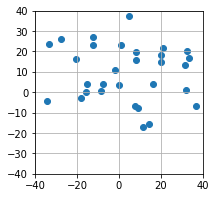

In [209]:
plt.figure(figsize = (3,3))
plt.scatter(truth['center_x'], truth['center_y'])
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

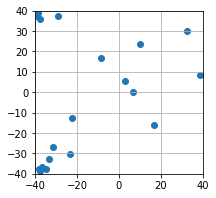

In [210]:
plt.figure(figsize = (3,3))
plt.scatter(pred['x_ctr_original'], pred['y_ctr_original'])
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

In [216]:
fitted.columns

Index(['scene_id', 'sample_id', 'category_id', 'score', 'bbox', 'x_pred',
       'y_pred', 'w_pred', 'h_pred', 'w_original', 'h_original',
       'x_ctr_original', 'y_ctr_original'],
      dtype='object')

(array([2., 2., 2., 4., 0., 0., 2., 0., 5., 2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

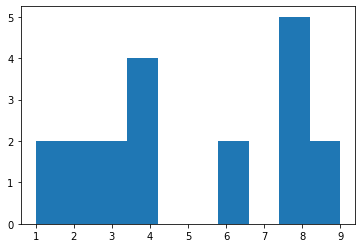

In [217]:
plt.hist(fitted['category_id'])

(array([26.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <a list of 10 Patch objects>)

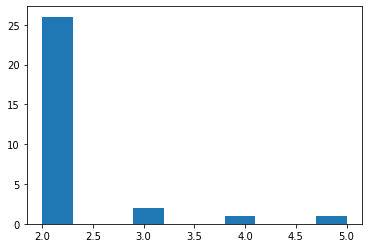

In [218]:
plt.hist(truth['category_id'])